# Download & Process an open fNIRS dataset

**Author**: Guillaume Dumas  
**Date**: 2022-11-16  
**Note**: This notebook will download ~500MB of data.

## Overview

In this notebook we:

- Import necessary libraries and configure the environment.
- Download a large open fNIRS dataset using Pooch.
- Uncompress the downloaded archive.
- Loop through all dyads in the dataset to check that the recordings of children and parents have the same duration.
- Preprocess the fNIRS data (remove short channels, convert raw intensity to optical density, perform quality check, convert to haemoglobin, and filter out heart rate signals).
- Create fixed-length epochs from the preprocessed data and import them into HyPyP.
- Compute and visualize cross-wavelet coherence between participants.
- (Further processing and statistical analysis are indicated to be continued.)

## Import Libraries

The following cells configure interactive plotting, autoreload, and import the necessary packages for file retrieval, data handling, fNIRS processing using MNE, and visualization.

In [1]:
# Enable inline plotting and autoreloading of modules
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print('Matplotlib inline and autoreload enabled. Warnings suppressed.')

Matplotlib inline and autoreload enabled. Warnings suppressed.


In [2]:
# Import required libraries
import pooch  # For downloading data
from zipfile import ZipFile  # For uncompressing archives
import os
import mne  # MNE for fNIRS processing
import matplotlib.pyplot as plt
from itertools import compress  # For selecting channels
import numpy as np
import hypyp  # HyPyP for connectivity and further analyses

print('All required libraries imported.')

All required libraries imported.


## Download the Whole Dataset

The dataset (approx. 500MB) is downloaded using Pooch. For more details on the dataset, see the [Paper](https://doi.org/10.1038/s41597-022-01751-2) and [Data](https://doi.org/10.21979/N9/35DNCW). 

Pooch documentation: [https://www.fatiando.org/pooch/latest/](https://www.fatiando.org/pooch/latest/)

In [3]:
# Download the dataset archive using Pooch
file_path = pooch.retrieve(
    fname="fathers.zip",
    url="https://researchdata.ntu.edu.sg/api/access/datafile/91950?gbrecs=true",
    known_hash="md5:786e0c13caab4fc744b93070999dff63",
    progressbar=True
)

print('Dataset downloaded to:', file_path)

Dataset downloaded to: /Users/blackstar/Library/Caches/pooch/fathers.zip


## Uncompress the Archive

The downloaded data is stored in Pooch's cache folder. We uncompress the ZIP archive to extract the dataset. 

Refer to the [ZipFile documentation](https://docs.python.org/3/library/zipfile.html) for more details.

In [4]:
# Determine the directory of the downloaded file
pooch_path = os.path.dirname(file_path)

# Uncompress the archive
with ZipFile(file_path, 'r') as zip:
    zip.extractall(path=pooch_path)
    # Use the first file in the archive to set the data path
    data_path = os.path.join(pooch_path, zip.filelist[0].filename)

print('Data uncompressed. Data path:', data_path)

Data uncompressed. Data path: /Users/blackstar/Library/Caches/pooch/fathers/


## Loop Through All Dyads and Check Durations

Each dyad in the dataset contains data for a child and their father recorded with NIRx. For each dyad, we load the data for both participants and verify that the duration of the recordings is identical. This check ensures that the subsequent analyses compare synchronized data.

In [5]:
for dyad in os.listdir(data_path):
    
    # Load the NIRx data for the child
    child_path = os.path.join(data_path, dyad, 'child')
    hdr_child = [f for f in os.listdir(child_path) if f[-3:] == 'hdr'][0]
    raw_child = mne.io.read_raw_nirx(fname=os.path.join(child_path, hdr_child))
    
    # Load the NIRx data for the parent
    parent_path = os.path.join(data_path, dyad, 'parent')
    hdr_parent = [f for f in os.listdir(parent_path) if f[-3:] == 'hdr'][0]
    raw_parent = mne.io.read_raw_nirx(fname=os.path.join(parent_path, hdr_parent))

    # Check that both recordings have the same duration
    assert raw_child.times[-1] == raw_parent.times[-1], "Warning: Files have different durations!"

print('All dyads have matching recording durations.')

Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS20/child/NIRS-2019-11-17_002.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS20/parent/NIRS-2019-11-17_002.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS27/child/NIRS-2019-11-16_006.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS27/parent/NIRS-2019-11-16_006.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS11/child/NIRS-2019-11-09_001.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS11/parent/NIRS-2019-11-09_001.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS29/child/NIRS-2019-11-17_004.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS29/parent/NIRS-2019-11-17_004.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS16/child/NIRS-2019-10-29_002.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS16/parent/NIRS-2019-10-29_002.hdr
Loading /Users/blackstar/Library/Caches/pooch/fathers/FCS28/child/NIRS-2019-11-10_003.hdr
Loadi

## Preprocess the fNIRS Data

The following steps preprocess the fNIRS data for one participant (parent). Similar processing is performed for the child data later.

### Remove Short Channels

We first remove channels with a source-detector distance that is too short (i.e. less than 0.01 m) using MNE functions.

Using matplotlib as 2D backend.


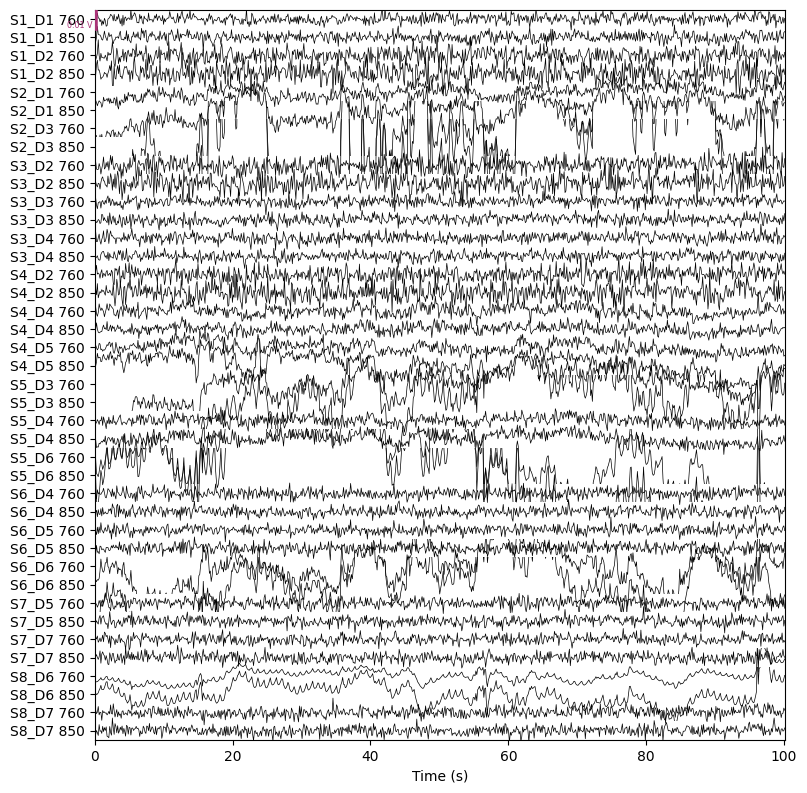

Short channels removed from parent data.


In [6]:
# Select fNIRS channels from the parent's data
picks = mne.pick_types(raw_parent.info, meg=False, fnirs=True)

# Compute source-detector distances
dists = mne.preprocessing.nirs.source_detector_distances(raw_parent.info, picks=picks)

# Retain only channels with distance greater than 0.01 m
raw_parent.pick(picks[dists > 0.01])

# Plot the remaining channels (set duration and scalings for visibility)
raw_parent.plot(n_channels=len(raw_parent.ch_names), duration=100, scalings='auto', show_scrollbars=False)
plt.show()

print('Short channels removed from parent data.')

### Converting from Raw Intensity to Optical Density

Next, we convert the raw intensity data to optical density. This step is essential for subsequent haemoglobin concentration calculations.

Reading 0 ... 4848  =      0.000 ...   620.544 secs...


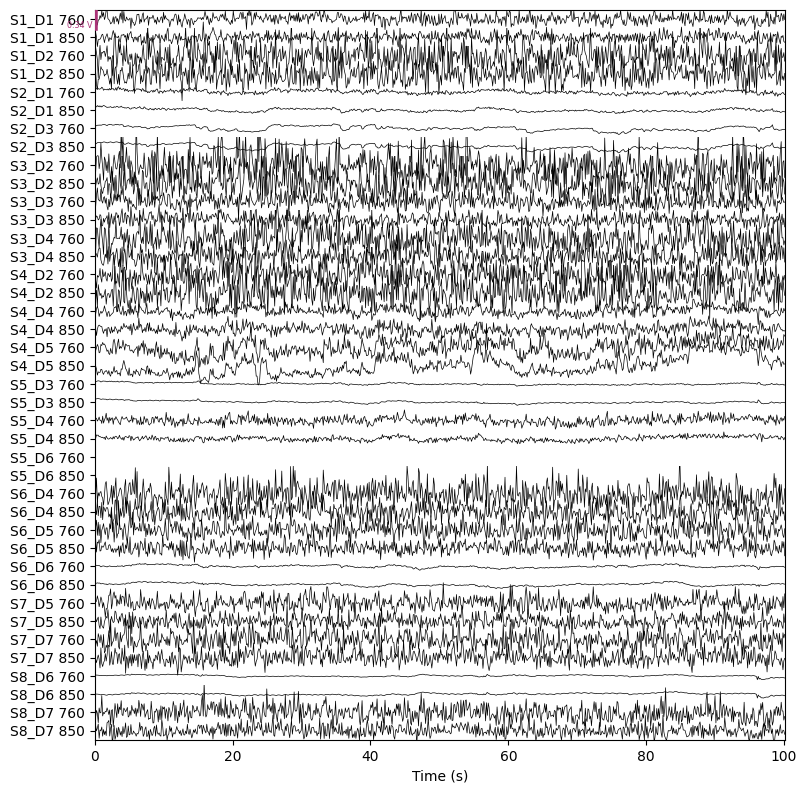

Optical density computed and plotted for parent data.


In [7]:
# Convert raw intensity data to optical density for the parent's data
raw_od = mne.preprocessing.nirs.optical_density(raw_parent)

# Plot the optical density data
raw_od.plot(n_channels=len(raw_od.ch_names), duration=100, scalings='auto', show_scrollbars=False)
plt.show()

print('Optical density computed and plotted for parent data.')

### Quality Check

We assess the quality of the optical density data using the scalp coupling index (SCI). The SCI measures the presence of a prominent synchronous cardiac signal. Channels with SCI below a chosen threshold are marked as bad.

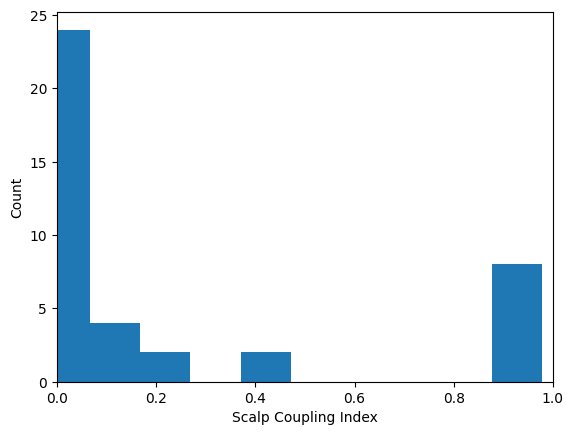

Quality check completed; bad channels removed based on SCI.


In [8]:
# Compute the scalp coupling index (SCI) for the parent's optical density data
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)

# Plot a histogram of the SCI values
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
plt.show()

# Mark channels with SCI below 0.1 as bad
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.1))

# Select good channels
picks = mne.pick_types(raw_od.info, meg=False, fnirs=True, exclude='bads')
raw_od_clean = raw_od.copy().pick(picks)

print('Quality check completed; bad channels removed based on SCI.')

### Converting from Optical Density to Haemoglobin Concentrations

Using the Beer-Lambert law, we convert the optical density data into haemoglobin concentrations. The parameter `ppf` is set to 0.1 as an example value.

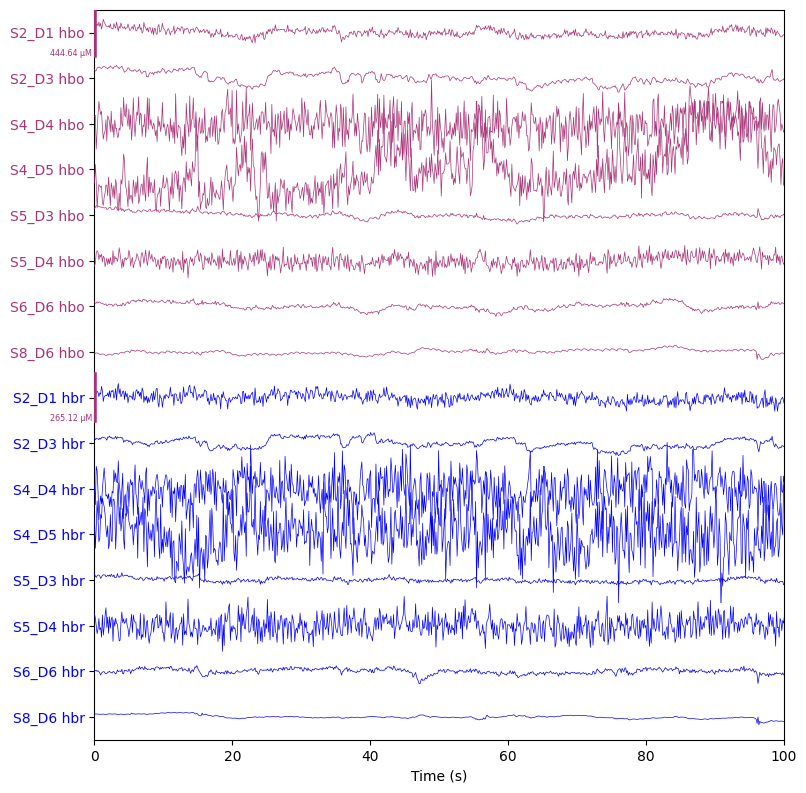

Conversion to haemoglobin completed and plotted for parent data.


In [9]:
# Convert optical density to haemoglobin concentration for parent's data
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_clean, ppf=0.1)

# Plot the haemoglobin data
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=100, scalings='auto', show_scrollbars=False, theme="light")
plt.show()

print('Conversion to haemoglobin completed and plotted for parent data.')

### Removing Heart Rate from the Signal

We inspect the power spectral density (PSD) before filtering, then apply a bandpass filter to remove heart rate components, and finally inspect the PSD again after filtering.

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


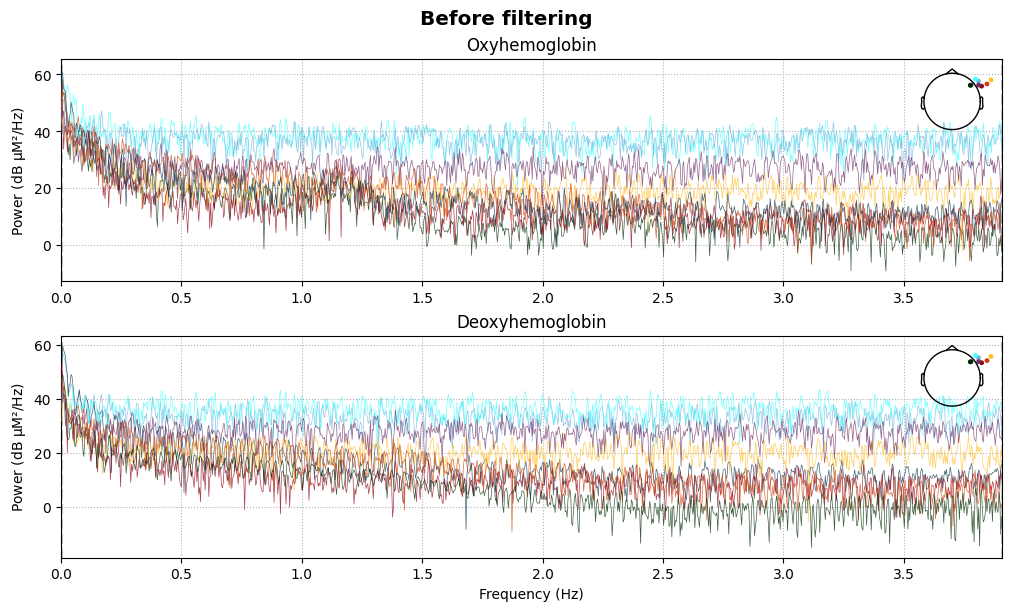

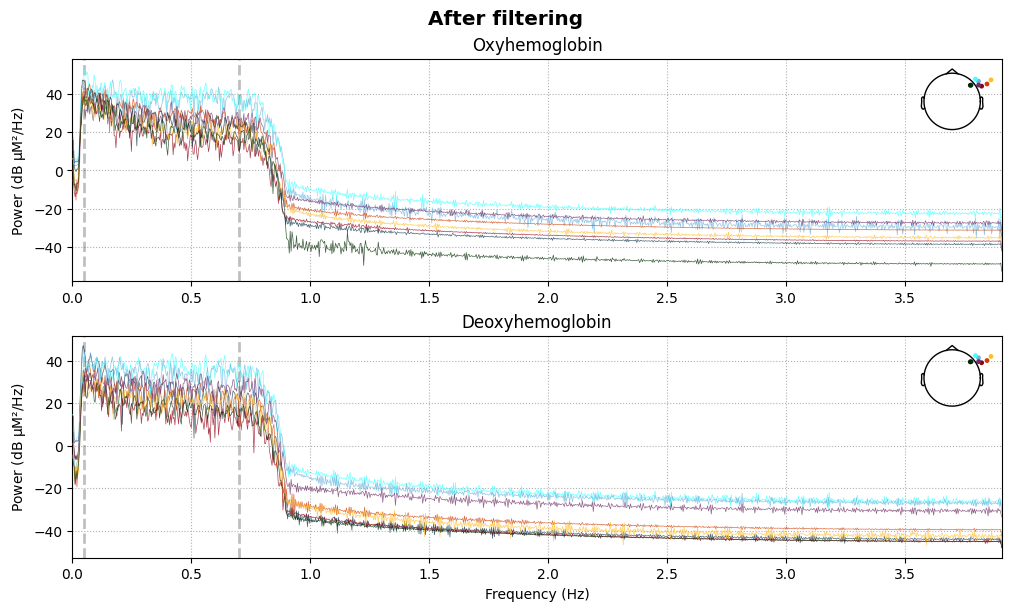

Heart rate removed from parent data.


In [10]:
# Compute and plot the PSD before filtering
fig = raw_haemo.compute_psd().plot()
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)

# Filter the haemoglobin data to remove heart rate (0.05-0.7 Hz)
raw_haemo_parent = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)

# Compute and plot the PSD after filtering
fig = raw_haemo_parent.compute_psd().plot()
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
plt.show()

print('Heart rate removed from parent data.')

### Process the Data for the Other Participant (Child)

We apply the same preprocessing steps to the child's data.

In [11]:
# Process child's data: remove short channels
picks = mne.pick_types(raw_child.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(raw_child.info, picks=picks)
raw_child.pick(picks[dists > 0.01])

# Convert child's data from raw intensity to optical density
raw_od = mne.preprocessing.nirs.optical_density(raw_child)

# Quality check for child's data
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.1))
picks = mne.pick_types(raw_od.info, meg=False, fnirs=True, exclude='bads')
raw_od_clean = raw_od.copy().pick(picks)

# Convert optical density to haemoglobin for child's data
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_clean, ppf=0.1)

# Filter child's haemoglobin data
raw_haemo_child = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)

print('Child data preprocessed: haemoglobin computed and filtered.')

Reading 0 ... 4848  =      0.000 ...   620.544 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Child data preprocessed: haemoglobin computed and filtered.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Import into HyPyP

In [ ]:
duration = 30
epo_child = mne.make_fixed_length_epochs(raw_haemo_child, duration=duration, preload=True)
epo_parent = mne.make_fixed_length_epochs(raw_haemo_parent, duration=duration, preload=True)

## Compute and Visualize Cross-Wavelet Coherence

In [ ]:
freq_bins = 10
freqs = np.linspace(0.05, 1.0, freq_bins)
sfreq = epo_parent.info['sfreq']

common_chs = list(set(epo_child.ch_names) & set(epo_parent.ch_names))

epo_child = epo_child.pick(common_chs)
epo_parent = epo_parent.pick(common_chs)

data = hypyp.analyses.xwt(epo_child,
           epo_parent,
           freqs=freqs,
           mode='wtc')

In [ ]:
plt.figure(figsize=(10,6))

# Selecting the first channel pair and epoch, averaging over channels if necessary
data_2d = np.abs(data).mean(axis=(0, 1))[0, :, :]

plt.imshow(data_2d,
           aspect='auto',
           cmap='plasma',
           interpolation='lanczos')

plt.gca().invert_yaxis()
plt.ylabel('Frequencies (Hz)')
plt.xlabel('Time (s)')
plt.yticks(range(0, freq_bins, 2), 
           np.round(100*freqs[range(0, freq_bins, 2)])/100)
plt.ylim([0, freq_bins-1])

smax = data.shape[-1]
plt.xlim([0, smax])
plt.xticks(np.arange(0, smax+sfreq, sfreq), range(duration+1))

coi = 2.5*sfreq/freqs
rev_coi = data.shape[-1]-coi
idx = np.arange(len(freqs))
plt.plot(coi, idx, 'w')
plt.plot(data.shape[-1]-coi, idx, 'w')
plt.fill_between(coi, idx, hatch='X', fc='w', alpha=0.3)
plt.fill_between(rev_coi, idx, hatch='X', fc='w', alpha=0.3)

plt.axvspan(0, min(coi), hatch='X', fc='w', alpha=0.3)
plt.axvspan(smax, max(rev_coi), hatch='X', fc='w', alpha=0.3)

plt.colorbar()

## Now, let's process all the dataset

In [ ]:
for dyad in os.listdir(data_path):

    # Load the NIRx data for children and their fathers
    # https://mne.tools/stable/auto_tutorials/io/30_reading_fnirs_data.html

    child_path = os.path.join(data_path, dyad, 'child')
    hdr_child = [f for f in os.listdir(child_path) if f[-3:] == 'hdr'][0]
    raw_child = mne.io.read_raw_nirx(fname=os.path.join(child_path, hdr_child))

    parent_path = os.path.join(data_path, dyad, 'parent')
    hdr_parent = [f for f in os.listdir(parent_path) if f[-3:] == 'hdr'][0]
    raw_parent = mne.io.read_raw_nirx(
        fname=os.path.join(parent_path, hdr_parent))

    # Preprocessing

    # Processing
    # Storing in Pandas dataframe the connectivity

## Statistical Analysis and Visualization

> To be continued...